## Binary classification with XGBoost for Electrical Theft

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier


In [2]:
# The original State Grid Corporation of China (SGCC) dataset used for training models in this project 
# contains 42,372 rows and 1,036 columns. It was utilized for extensive data cleaning and 
# feature selection to train the XGBoost model.

# Due to its large size (~163 MB), it cannot be hosted directly on GitHub, 
# but it is available on Kaggle: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset

# For demonstration and preview purposes, this project uses a smaller version of the SGCC dataset  
# named `datasetsmall.csv`, which contains 25,863 rows and 28 columns, and is approximately 3.8 MB in size.

# Load the smaller dataset for preview
data = pd.read_csv('../data/raw/datasetsmall.csv')
data.head()


,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,1/19/2014,1/20/2014,1/21/2014,1/22/2014,1/23/2014,1/24/2014,1/25/2014,1/26/2014,CONS_NO,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,A0E791400CF1C48C43DC26A68227854A,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,B415F931D3BFB17ACEF48BC648B04FC2,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,DE8E1EAE4E578C0CEF92D1E23499888F,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,2952491E940C9040B188B3C9095910D6,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,DBEED8FD0E7F5E0D1BAF1F86F4983459,1


In [3]:
data.shape

(25863, 28)

## Data Cleaning


In [4]:
#I will drop the CONS_NO column since it seems to provide no information as well as being of string type
data = data.drop("CONS_NO", axis=1)

In [5]:

# Check summary statistics
summary_stats = data.describe()
summary_stats


,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,1/18/2014,1/19/2014,1/20/2014,1/21/2014,1/22/2014,1/23/2014,1/24/2014,1/25/2014,1/26/2014,FLAG
count,25863.000000,25861.000000,25858.000000,25861.000000,25861.000000,25861.000000,25860.000000,25863.000000,25862.000000,25863.000000,...,25857.000000,25857.000000,25856.000000,25854.000000,25855.000000,25845.000000,25851.000000,25851.000000,25849.000000,25863.000000
mean,7.168849,7.059998,6.707204,7.238823,7.394637,6.940999,7.273597,6.870441,6.964631,6.963363,...,7.064962,6.862818,6.828256,7.182345,7.368399,7.297437,7.068392,26.825118,7.009302,0.082048
std,34.135296,30.093066,31.231875,49.520129,41.473626,37.594592,64.137639,34.869891,39.717148,40.054462,...,33.972804,33.817870,31.921140,30.028777,35.876500,28.096731,25.523192,3203.065614,27.077518,0.274443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.310000,3.400000,3.110000,3.350000,3.560000,3.330000,3.120000,3.220000,3.130000,2.880000,...,3.330000,3.110000,3.240000,3.600000,3.580000,3.630000,3.580000,3.620000,3.610000,0.000000
75%,8.910000,8.570000,8.110000,8.320000,8.880000,8.290000,8.090000,8.120000,8.220000,8.180000,...,8.770000,8.580000,8.510000,9.040000,9.150000,9.310000,9.055000,9.110000,9.040000,0.000000
max,3318.000000,2500.000000,2674.000000,5670.000000,4854.000000,4170.000000,7119.810000,3546.000000,4416.000000,3966.000000,...,3258.000000,3876.000000,3228.000000,3054.000000,3840.000000,2462.000000,1956.000000,514991.780000,2272.000000,1.000000


In [6]:
# by row
df=data.drop('FLAG',axis=1)
df=df.apply(pd.DataFrame.describe, axis=1)
df['FLAG']=data['FLAG']
df

,count,mean,std,min,25%,50%,75%,max,FLAG
0,26.0,1979.076923,722.138874,340.00,1418.5000,2251.500,2422.0000,3167.00,1
1,26.0,3071.538462,1516.833154,96.00,2167.5000,3366.000,3964.5000,5670.00,1
2,26.0,1319.884615,132.567823,1012.20,1270.6000,1338.200,1413.3000,1540.60,1
3,26.0,1013.838462,375.631496,0.00,1093.0500,1149.900,1181.4000,1228.20,0
4,26.0,1293.167308,126.726934,1006.65,1224.9750,1309.800,1397.1750,1463.10,1
...,...,...,...,...,...,...,...,...,...
25858,26.0,111.875385,27.895447,0.00,102.1750,114.595,125.4125,146.30,0
25859,26.0,52.330769,60.431421,0.00,0.0000,0.000,102.6000,153.10,1
25860,26.0,111.634615,62.014469,0.00,103.3425,120.750,165.4400,176.44,0
25861,24.0,6.512083,3.127295,0.00,5.3275,7.120,8.4025,12.00,1


## Exploratory Data Analysis - EDA

In [7]:
# Check the number of instances of each class
class_counts = data['FLAG'].value_counts()
class_counts

FLAG
0    23741
1     2122
Name: count, dtype: int64

Text(0.5, 1.0, 'FLAG Imbalanced Distribution')

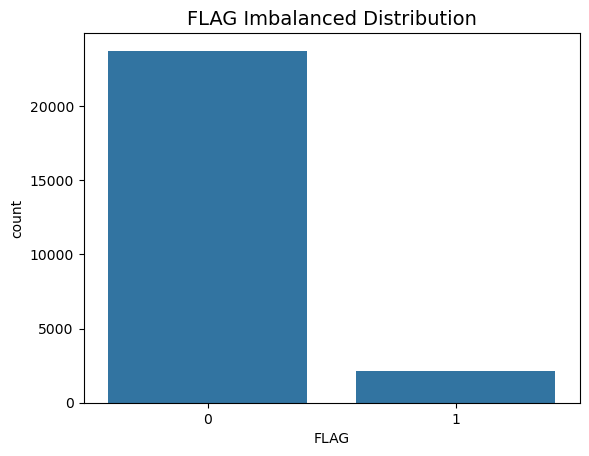

In [8]:
sns.countplot(x=data['FLAG'])
plt.title('FLAG Imbalanced Distribution', fontsize=14)

In [9]:
# Get the number of missing values and percentage
missing_percentage = (data.isna().sum() / len(data)) * 100
print(missing_percentage)
# Assuming your DataFrame is named "data"
missing_values = data.isna().sum()

# To get the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

print("Missing values per column:")
print([x for x in missing_values if x!=0])
print("Total missing values in the DataFrame:", total_missing_values)

01/01/2014    0.000000
01/02/2014    0.007733
01/03/2014    0.019333
01/04/2014    0.007733
01/05/2014    0.007733
01/06/2014    0.007733
01/07/2014    0.011600
01/08/2014    0.000000
01/09/2014    0.003867
01/10/2014    0.000000
01/11/2014    0.003867
01/12/2014    0.000000
1/13/2014     0.000000
1/14/2014     0.007733
1/15/2014     0.015466
1/16/2014     0.011600
1/17/2014     0.023199
1/18/2014     0.023199
1/19/2014     0.023199
1/20/2014     0.027066
1/21/2014     0.034799
1/22/2014     0.030932
1/23/2014     0.069597
1/24/2014     0.046398
1/25/2014     0.046398
1/26/2014     0.054131
FLAG          0.000000
dtype: float64
Missing values per column:
[2, 5, 2, 2, 2, 3, 1, 1, 2, 4, 3, 6, 6, 6, 7, 9, 8, 18, 12, 12, 14]
Total missing values in the DataFrame: 125


In [10]:
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

['01/02/2014', '01/03/2014', '01/04/2014', '01/05/2014', '01/06/2014', '01/07/2014', '01/09/2014', '01/11/2014', '1/14/2014', '1/15/2014', '1/16/2014', '1/17/2014', '1/18/2014', '1/19/2014', '1/20/2014', '1/21/2014', '1/22/2014', '1/23/2014', '1/24/2014', '1/25/2014', '1/26/2014']


In [11]:
# Filling missing values with interpolation

data = data.interpolate(method='linear', axis=0)

In [12]:
# Now we check if there's any missing data left
missing_values = data.isna().sum()
print(missing_values.sum())
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

0
[]


In [13]:
data.head()

,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,1/18/2014,1/19/2014,1/20/2014,1/21/2014,1/22/2014,1/23/2014,1/24/2014,1/25/2014,1/26/2014,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,2369.0,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3258.0,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1351.4,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,1158.6,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1398.6,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,1


## Extracting Features

In [14]:
# Identify and Clean Date Columns
date_columns = [col for col in data.columns if col not in ['FLAG', 'CONS_NO']]

# Clean and Prepare Consumption Data
data[date_columns] = data[date_columns].apply(pd.to_numeric, errors='coerce')
data[date_columns] = data[date_columns].fillna(data[date_columns].mean())

# Convert column names to datetime format
datetime_columns = pd.to_datetime(date_columns, errors='coerce')
data_only = data[date_columns].copy()
data_only.columns = datetime_columns

# Core Statistical Features
features = pd.DataFrame(index=data.index)
features['mean_consumption'] = data_only.mean(axis=1)
features['std_consumption'] = data_only.std(axis=1)
features['sum_consumption'] = data_only.sum(axis=1)
features['median_consumption'] = data_only.median(axis=1)
features['max_consumption'] = data_only.max(axis=1)
features['min_consumption'] = data_only.min(axis=1)
features['count_valid_days'] = data_only.count(axis=1)

# Temporal Features
daily_diff = data_only.diff(axis=1).abs()
features['mean_daily_diff'] = daily_diff.mean(axis=1)

features['lag_1'] = data_only.shift(1, axis=1).iloc[:, -1]
features['lag_7'] = data_only.shift(7, axis=1).iloc[:, -1]

# Monthly average consumption
monthly_avg = data_only.T.groupby(pd.Grouper(freq='ME')).mean().T
monthly_avg.columns = [f'monthly_avg_{col.strftime("%Y_%m")}' for col in monthly_avg.columns]
features = pd.concat([features, monthly_avg], axis=1)

# Anomaly / Outlier Features
z_scores = (data_only - features['mean_consumption'].values[:, None]) / features['std_consumption'].replace(0, 1).values[:, None]
features['num_z_outliers'] = (z_scores.abs() > 3).sum(axis=1)

rolling_mean = data_only.rolling(window=7, axis=1, min_periods=1).mean()
features['mean_rolling_deviation'] = (data_only - rolling_mean).abs().mean(axis=1)

q1 = data_only.quantile(0.25, axis=1)
q3 = data_only.quantile(0.75, axis=1)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
features['num_iqr_outliers'] = ((data_only.lt(lower_bound, axis=0) | data_only.gt(upper_bound, axis=0)).sum(axis=1))

# Adding FLAG Column as Target
features['FLAG'] = data['FLAG']

# Save and Preview
# features.to_csv('../data/processed/cleaned_and_processed_data.csv', index=False) #Uncomment to save file

print("Selected Features Extracted:")
print(features.columns.tolist())
print(features.head())


/tmp/ipykernel_27128/457518375.py:39: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_mean = data_only.rolling(window=7, axis=1, min_periods=1).mean()


Selected Features Extracted:
['mean_consumption', 'std_consumption', 'sum_consumption', 'median_consumption', 'max_consumption', 'min_consumption', 'count_valid_days', 'mean_daily_diff', 'lag_1', 'lag_7', 'monthly_avg_2014_01', 'num_z_outliers', 'mean_rolling_deviation', 'num_iqr_outliers', 'FLAG']
   mean_consumption  std_consumption  sum_consumption  median_consumption  \
0       1979.076923       722.138874         51456.00              2251.5   
1       3071.538462      1516.833154         79860.00              3366.0   
2       1319.884615       132.567823         34317.00              1338.2   
3       1013.838462       375.631496         26359.80              1149.9   
4       1293.167308       126.726934         33622.35              1309.8   

   max_consumption  min_consumption  count_valid_days  mean_daily_diff  \
0           3167.0           340.00                26          807.400   
1           5670.0            96.00                26         1140.720   
2           154